
# Convolutional Neural Network

## Background
A Convolutional Neural Network (CNN or ConvNet) is a type of deep learning model most commonly used for analyzing visual imagery. As a system inspired by the mammel's visual cortex, it's the technology behind tasks like image recognition, object detection, and facial recognition.

Computer vision is the primary and most common use of ConvNet.  

- Social media platforms use it to automatically suggest tags for people (facial recognition) or objects in your photos.
- Cashier-less stores (like Amazon Go) use it to track what items you pick up.
- Self-Driving cars use it to detect and react to people, other cars, traffic lights, and road signs.

While most famous for images, CNNs can also be applied to sequential data :

- Sentiment Analysis: Determining if a product review or tweet is positive, negative, or neutral.
- Text Classification: Automatically sorting documents or articles by topic.
- Speech Recognition: Used in virtual assistants (like Siri or Google Assistant) to help process and understand the sounds in your voice.
- Finance: Analyzing time-series data (like stock charts) to detect patterns or fraudulent activity.

## Objectives

1. Review data loading and pre-processing using PyTorch. 
2. Practice construction of Convolutional Neural Network
3. Practice model training with PyTorch.

<font color=582c83>

## Exercises

1. (30%) Exercise 1: ConvNet construction
2. (20%) Exercise 2: Training function
3. (10%) Exercise 3: Validationion function
4. (30%) Exercise 4: Model optimization
5. (10%) Exercise 5: New image classification

</font>

## 1. Load Data
We will train a deep learning model using the ImageNette dataset.
Imagenette is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

- The raw images in ImageNette dataset have various resolutions, and we will resize them to 160x120x3.
- Two dataloaders will be created for easily batching in training and validation.  

Number of training samples: 9469
Number of validation samples: 3925
Features shape: torch.Size([3, 160, 120])
Categories: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


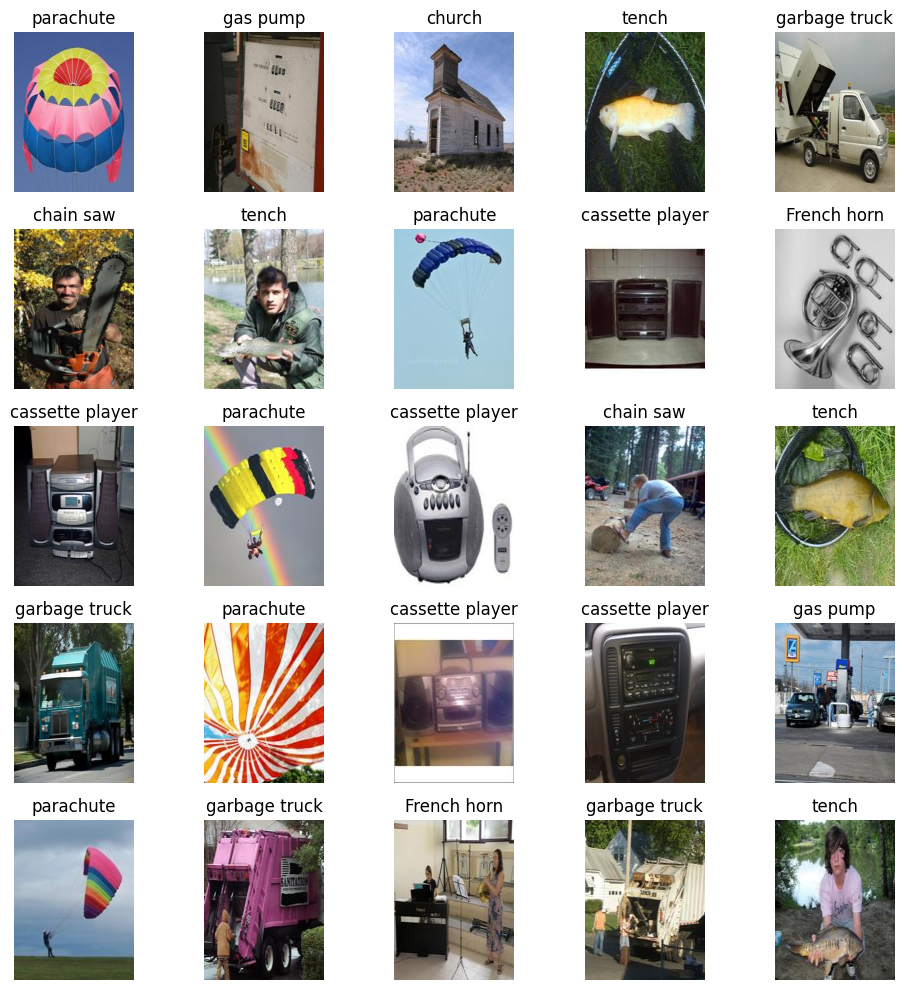

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, RGB, Resize, ToDtype
import matplotlib.pyplot as plt

# Construct transform pipeline for input features
transform_pipeline = Compose([
    ToImage(),
    RGB(),
    Resize((160, 120)),
    ToDtype(torch.float32, scale=True),
])

# Download datasets
dataset_train = datasets.Imagenette(
    root="data",
    split="train",
    size="160px",
    download=True,
    transform=transform_pipeline,
)
labels = [c[0] for c in dataset_train.classes]

dataset_val = datasets.Imagenette(
   root="data",
    split="val",
    size="160px",
    download=True,
    transform=transform_pipeline,
)


print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")
print(f"Features shape: {dataset_train[0][0].shape}")
print(f"Categories: {labels}")

# Create dataloaders
batch_size = 64
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    sample_img = sample_batch_train[0][i].permute(1, 2, 0).numpy()  # reconstruct image to (H, W, C)
    sample_cls = sample_batch_train[1][i].item()
    sample_lbl = labels[sample_cls]
    axs[i//5, i%5].imshow(sample_img)
    axs[i//5, i%5].set_title(sample_lbl)
    axs[i//5, i%5].axis("off")
plt.tight_layout()


## 2. Convolutional Neural Network (ConvNet) Construction

Design your ConvNet's architecture to classify images (shape: `(3, 160, 120)`) into 10 categories.
The output feature matrix dimension can be computed using the following equation.

$$
W_{out} = \frac{W_{in} - K + 2P}{S} + 1
$$
Given the dimension of the input matrix (either horizontal or vertical), $W_{in}$ is the length of the corresponding input matrix's dimension, $K$ is the kernel/filter length, $P$ is the padding length, $S$ is the stride of convolution. $W_{out}$ is the length of the corresponding output matrix's dimension.

For example, if the input matrix is with shape `(5, 8)`, a `(3, 3)` kernel applied on 1 pixel padded input with stride of 2 will output a `(3, 4)` matrix.

> Check this [post](https://www.geeksforgeeks.org/machine-learning/cnn-introduction-to-padding/) for more details.

### <font color=#582c83> (30%) Exercise 1: ConvNet construction </font>



In [ ]:
import torch.nn as nn


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv24 = nn.Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
        self.conv32 = nn.Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2))
        self.conv64_5 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
        self.conv64_3 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

        self.fc1 = nn.Linear(64*8*13, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv24(x))  
        x = self.relu(self.conv32(x))
        x = self.relu(self.conv64_5(x))
        x = self.relu(self.conv64_3(x))
        x = self.relu(self.conv64_3(x))

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}.")
model = ConvNet().to(device)  # use GPU if available
# print(model)`(5, 8)`
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 160, 120))

Using cuda.


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [64, 10]                  --
├─Conv2d: 1-1                            [64, 24, 78, 58]          1,824
├─ReLU: 1-2                              [64, 24, 78, 58]          --
├─Conv2d: 1-3                            [64, 32, 37, 27]          19,232
├─ReLU: 1-4                              [64, 32, 37, 27]          --
├─Conv2d: 1-5                            [64, 64, 17, 12]          51,264
├─ReLU: 1-6                              [64, 64, 17, 12]          --
├─Conv2d: 1-7                            [64, 64, 15, 10]          36,928
├─ReLU: 1-8                              [64, 64, 15, 10]          --
├─Conv2d: 1-9                            [64, 64, 13, 8]           (recursive)
├─ReLU: 1-10                             [64, 64, 13, 8]           --
├─Flatten: 1-11                          [64, 6656]                --
├─Linear: 1-12                           [64, 128]           

## 3. ConvNet Training

### <font color=#582c83> (20%) Exercise 2: Training function </font>
Model optimization in one epoch using all samples in the dataset which are organized in batches.

Repeat until all batches are used:
1. Get a batch of features and lables.
2. Make prediction.
3. Calculate loss
4. Compute gradients of loss with back-propagation.
5. Update model parameters

In [3]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    sum_losses, sum_correct_counts = 0, 0
    for batch_index, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        batch_preds = model(X)
        batch_loss = loss_fn(batch_preds, y)
        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Stats
        sum_losses += batch_loss.item()
        sum_correct_counts += (batch_preds.argmax(1) == y).type(torch.float).sum().item()

        # Log
        if batch_index % 50 == 0:  # print every 50 batches
            print(f"Training batch: [{(batch_index+1)*len(y):>5d}/{size:>5d}] loss: {batch_loss.item():>7f}")

    # Summarize epoch metrics
    epoch_loss = sum_losses / len(dataloader)
    epoch_accuracy = sum_correct_counts / size
    print(f"Training: \n Accuracy: {(100*epoch_accuracy):>0.1f}%, Avg loss: {epoch_loss:>8f} \n")
    return epoch_loss, epoch_accuracy



### <font color=#582c83> (10%) Exercise 3: Validationion function </font>
Classification accuracy is an important metric. 
Calculate accuracy using validation dataset. 

In [4]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    sum_losses, sum_correct_counts = 0, 0
    with torch.no_grad():   
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            sum_losses += loss_fn(pred, y).item()
            sum_correct_counts += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Summarize epoch metrics
    epoch_loss = sum_losses / len(dataloader)
    epoch_accuracy = sum_correct_counts / size
    print(f"Validation: \n Accuracy: {(100*epoch_accuracy):>0.1f}%, Avg loss: {epoch_loss:>8f} \n")
    return epoch_loss, epoch_accuracy


### <font color=#582c83> (30%) Exercise 4: Model optimization </font>
Use appropriate hyper-parameters and functions to optimize the ConvNet model.

> `SGD` is not the only optimization [algorithm](https://docs.pytorch.org/docs/stable/optim.html#algorithms)

<font color=red> Validation accuracy is expected to beyond **70%** </font>

Epoch 1
-------------------------------
Training batch: [   64/ 9469] loss: 2.294771
Training batch: [ 3264/ 9469] loss: 2.235614
Training batch: [ 6464/ 9469] loss: 2.107204
Training: 
 Accuracy: 19.1%, Avg loss: 2.177774 

Validation: 
 Accuracy: 26.1%, Avg loss: 2.039607 

Epoch 2
-------------------------------
Training batch: [   64/ 9469] loss: 1.983743
Training batch: [ 3264/ 9469] loss: 2.045574
Training batch: [ 6464/ 9469] loss: 1.974965
Training: 
 Accuracy: 28.5%, Avg loss: 1.993413 

Validation: 
 Accuracy: 27.7%, Avg loss: 1.984381 

Epoch 3
-------------------------------
Training batch: [   64/ 9469] loss: 1.915958
Training batch: [ 3264/ 9469] loss: 1.903147
Training batch: [ 6464/ 9469] loss: 1.737053
Training: 
 Accuracy: 31.6%, Avg loss: 1.931802 

Validation: 
 Accuracy: 31.2%, Avg loss: 1.931423 

Epoch 4
-------------------------------
Training batch: [   64/ 9469] loss: 1.775242
Training batch: [ 3264/ 9469] loss: 1.767019
Training batch: [ 6464/ 9469] loss: 1.9

(0.0, 1.0)

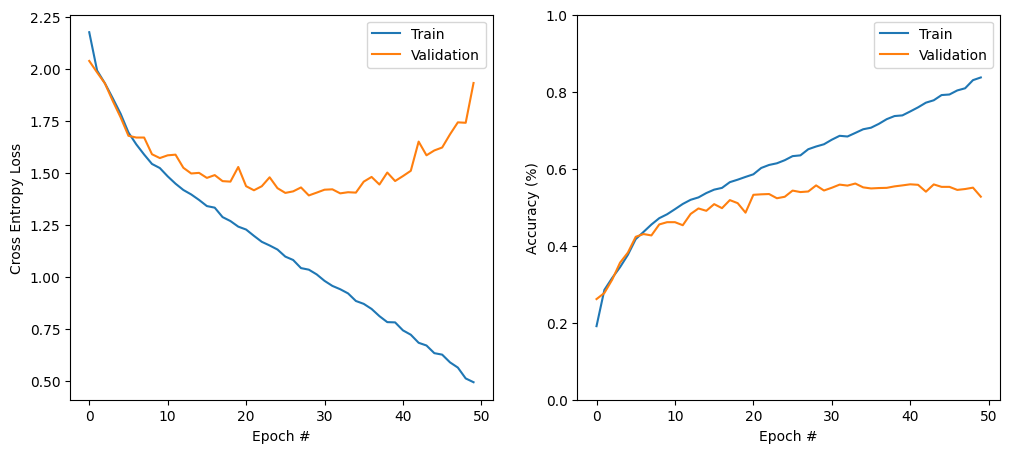

In [6]:
import torch.optim as optim

# Initialize model and parameters
model = ConvNet().to(device)
# Hyperparameterssize
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 50
# Metrics storage
losses_train, losses_val = [], []
accuracies_train, accuracies_val = [], []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    ep_loss_train, ep_acc_train = train(dataloader_train, model, loss_fn, optimizer)
    ep_loss_val, ep_acc_val = validate(dataloader_val, model, loss_fn)
    losses_train.append(ep_loss_train)
    accuracies_train.append(ep_acc_train)
    losses_val.append(ep_loss_val)
    accuracies_val.append(ep_acc_val)
print("Done!")

# Visualize training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses_train, range(num_epochs), losses_val)
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch #")
plt.ylabel("Cross Entropy Loss")
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), accuracies_train, range(num_epochs), accuracies_val)
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch #")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)

# Save model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

### 4. Test Model
There are 10 pictures prepared in the [test_images](./test_images/) directory (1 testing image in each category).
Please classify these images using the trained model.

### <font color=#582c83> (10%) Exercise 5: New image classification </font>

In [ ]:
from pathlib import Path
from torchvision.io import decode_image, ImageReadMode

test_dir = Path.cwd() / "example_test_images"  # locate dataset directory from this repo in the whole system
# test_dir = Path.cwd() / "test_images"  # locate dataset directory from this repo in the whole system


# Glob test files
test_files = list(test_dir.glob("**/*.jpg"))
# print(test_files)

# Predict test images with trained model
model.eval()
with torch.no_grad():  # ensure model will not be updated
    for file in test_files:
        img_raw = decode_image(file, mode=ImageReadMode.RGB)  # decode image file to pytorch tensor
        img_resize = Resize((160, 120))(img_raw)  # resize image to comply with model input size
        image_test = ToDtype(torch.float32, scale=True)(img_resize).unsqueeze(0)  # rescale and add batch dimension
        pred_test = model(image_test.to(device))
        print(f"Predicted {file.name} class: {labels[pred_test.argmax().item()]}")

Predicted A_resting_English_Springer_Spaniel.jpg class: English springer
Predicted golf-ball-on-t.jpg class: golf ball
Predicted church-tree-sky-landscape.jpg class: church
Predicted TincaTincaScales.jpg class: tench
Predicted apollochute.jpg class: parachute
Predicted Ferguson_portable_radio_cassette_recorder.jpg class: church
Predicted chainsaw.jpg class: chain saw
Predicted Garbage_Truck_front.jpg class: garbage truck
Predicted HornL.jpg class: garbage truck
Predicted filling-station.jpg class: church


In [25]:
image_test.shape

torch.Size([1, 3, 160, 120])

# Congrats on finishing this assignment!